# Testing photobleaching method

In [26]:
import numpy as np
import bokeh.io
import bokeh.plotting
import mscl.mcmc
import mscl.plotting
import mscl.process
import mscl.stats
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import theano.tensor as tt
colors = mscl.plotting.set_plotting_style()
%matplotlib inline

In [18]:
# Load the data
bleaching_data = pd.read_csv('../dilution_processing/20171129_sfGFP_10ngml_dilution/output/20171129_sfGFP_bleaching.csv')

In [22]:
# Group by strain.
auto_data = bleaching_data[bleaching_data['strain']=='autofluorescence']
delta_data = bleaching_data[bleaching_data['strain']=='delta']
auto_grouped = auto_data.groupby(['cell_id'])
delta_grouped = delta_data.groupby(['cell_id'])

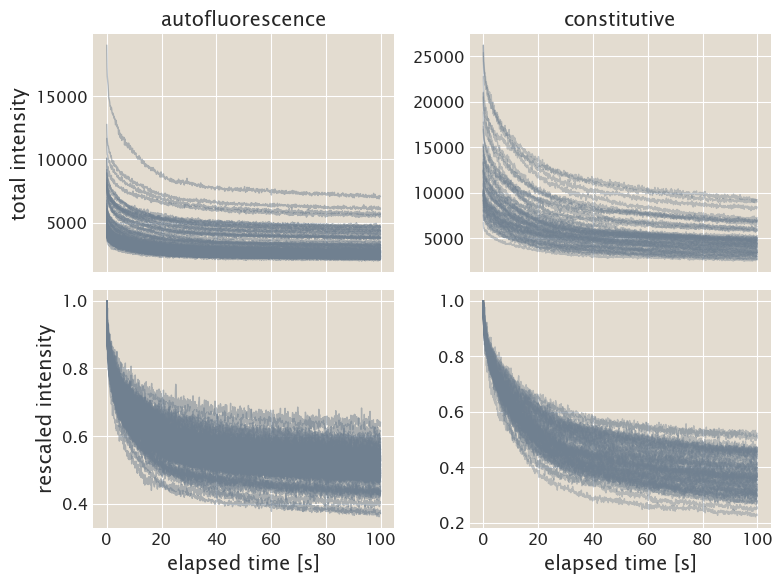

In [73]:
# Plot all of the rescaled values for each.
fig, ax = plt.subplots(2, 2, sharex=True)
ax[1, 0].set_xlabel('elapsed time [s]')
ax[1, 1].set_xlabel('elapsed time [s]')
ax[0, 0].set_ylabel('total intensity')
ax[1, 0].set_ylabel('rescaled intensity')
ax[0,0].set_title('autofluorescence')
ax[0, 1].set_title('constitutive')

for g, d in auto_grouped:
    _ = ax[0, 0].plot(d['elapsed_time_s'], d['total_intensity'], '-', lw=1, alpha=0.5, color='slategray')
    _ = ax[1, 0].plot(d['elapsed_time_s'], d['rescaled_intensity'], '-', lw=1, alpha=0.5, color='slategray')

for g, d in delta_grouped:
    _ = ax[0, 1].plot(d['elapsed_time_s'], d['total_intensity'], '-', lw=1, alpha=0.4, color='slategray')
    _ = ax[1, 1].plot(d['elapsed_time_s'], d['rescaled_intensity'], '-', lw=1, alpha=0.4, color='slategray')
    
plt.tight_layout()

## Heirarchical models.

In [50]:
n_cells = len(auto_data['cell_id'].unique())
with pm.Model() as auto_model:
    # Set the hyperpriors
    tau_mu = pm.HalfNormal('tau_mu', sd=100)
    tau_sig = pm.HalfNormal('tau_sig', sd=1)
    beta_mu = pm.Uniform('beta_mu', lower=0, upper=1)
    beta_sig = pm.HalfNormal('beta_sig', sd=1)
    bg_mu = pm.Uniform('bg_mu', lower=0, upper=1)
    bg_sig = pm.HalfNormal('bg_sig', sd=1)
    sig = pm.HalfNormal('sigma', sd=10)
    
    # Set the low-level priors 
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
    tau = pm.Normal('tau', mu=tau_mu, sd=tau_sig, shape=n_cells)
    beta = BoundedNormal('beta', mu=beta_mu, sd=beta_sig, shape=n_cells)
    bg = BoundedNormal('bg', mu=bg_mu, sd=bg_sig, shape=n_cells)
   
    # Set the observables.
    idx = auto_data['cell_id'].values.astype(int)
    time = auto_data['elapsed_time_s'].values
    obs = auto_data['rescaled_intensity'].values
    
    # Set the predicted value.
    I_theo = bg[idx] + beta[idx] * tt.exp(-time / tau[idx])
    
    # Define the likelihood and sample.
    likelihood = pm.Normal('like', mu=I_theo, sd=sig, observed=obs)
    advi = pm.ADVI()
    approx_fit = pm.fit(10000, method=advi)
    approx_trace = approx_fit.sample(5000)


Average Loss = 7,244.2: 100%|██████████| 10000/10000 [02:15<00:00, 73.56it/s]  
Finished [100%]: Average Loss = 6,794


In [68]:
# Extract the modes and HPD for informative priors
advi_df = mscl.mcmc.trace_to_dataframe(approx_trace, auto_model)
stats = mscl.mcmc.compute_statistics(advi_df)
auto_tau = np.mean(advi_df['tau_mu'])
auto_tau_sig = np.mean(advi_df['tau_sig'])
auto_beta = np.mean(advi_df['beta_mu'])
auto_beta_sig = np.mean(advi_df['beta_sig'])

In [71]:
n_cells = len(delta_data['cell_id'].unique())
with pm.Model() as delta_model:
    # Set the hyperpriors.
    gfp_tau = pm.HalfNormal('gfp_tau', sd=100)
    gfp_sig = pm.HalfNormal('gfp_sig', sd=1)
    bg_mu = pm.Uniform('bg_mu',lower=0, upper=1)
    bg_sig = pm.HalfNormal('bg_sig', sd=1)
    beta_mu = pm.Uniform('beta_mu', lower=0, upper=1)
    beta_sig = pm.HalfNormal('beta_sig', sd=1)
    sigma = pm.HalfNormal('sig', sd=10)
    
    # Set the low-level priors
    tau = pm.Normal('tau', mu=gfp_tau, sd=gfp_sig, shape=n_cells)
    bg = pm.Normal('bg', mu=bg_mu, sd=bg_sig, shape=n_cells)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sig, shape=n_cells)
    
    # Set the priors for the autofluorescence contribution.
#     auto_tau_mcmc = pm.Normal('auto_tau', mu=auto_tau, sd=auto_tau_sig, shape=n_cells)
#     auto_beta_mcmc = pm.Normal('auto_beta', mu=auto_beta, sd=auto_beta_sig, shape=n_cells)
    
    # Define the observables and compute.
    idx = delta_data['cell_id'].values
    time = delta_data['elapsed_time_s'].values
    obs = delta_data['rescaled_intensity'].values
    I_theo = bg[idx] + beta[idx] * tt.exp(-time / tau[idx]) 

    
    # Define the likelihood and sample.
    like = pm.Normal('like', mu=I_theo, sd=sigma, observed=obs)
    delta_trace = pm.sample(draws=100, tune=200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 300/300 [07:28<00:00,  1.50s/it]/Users/gchure/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 0 contains only 100 samples.
  % (self._chain_id, n))
/Users/gchure/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



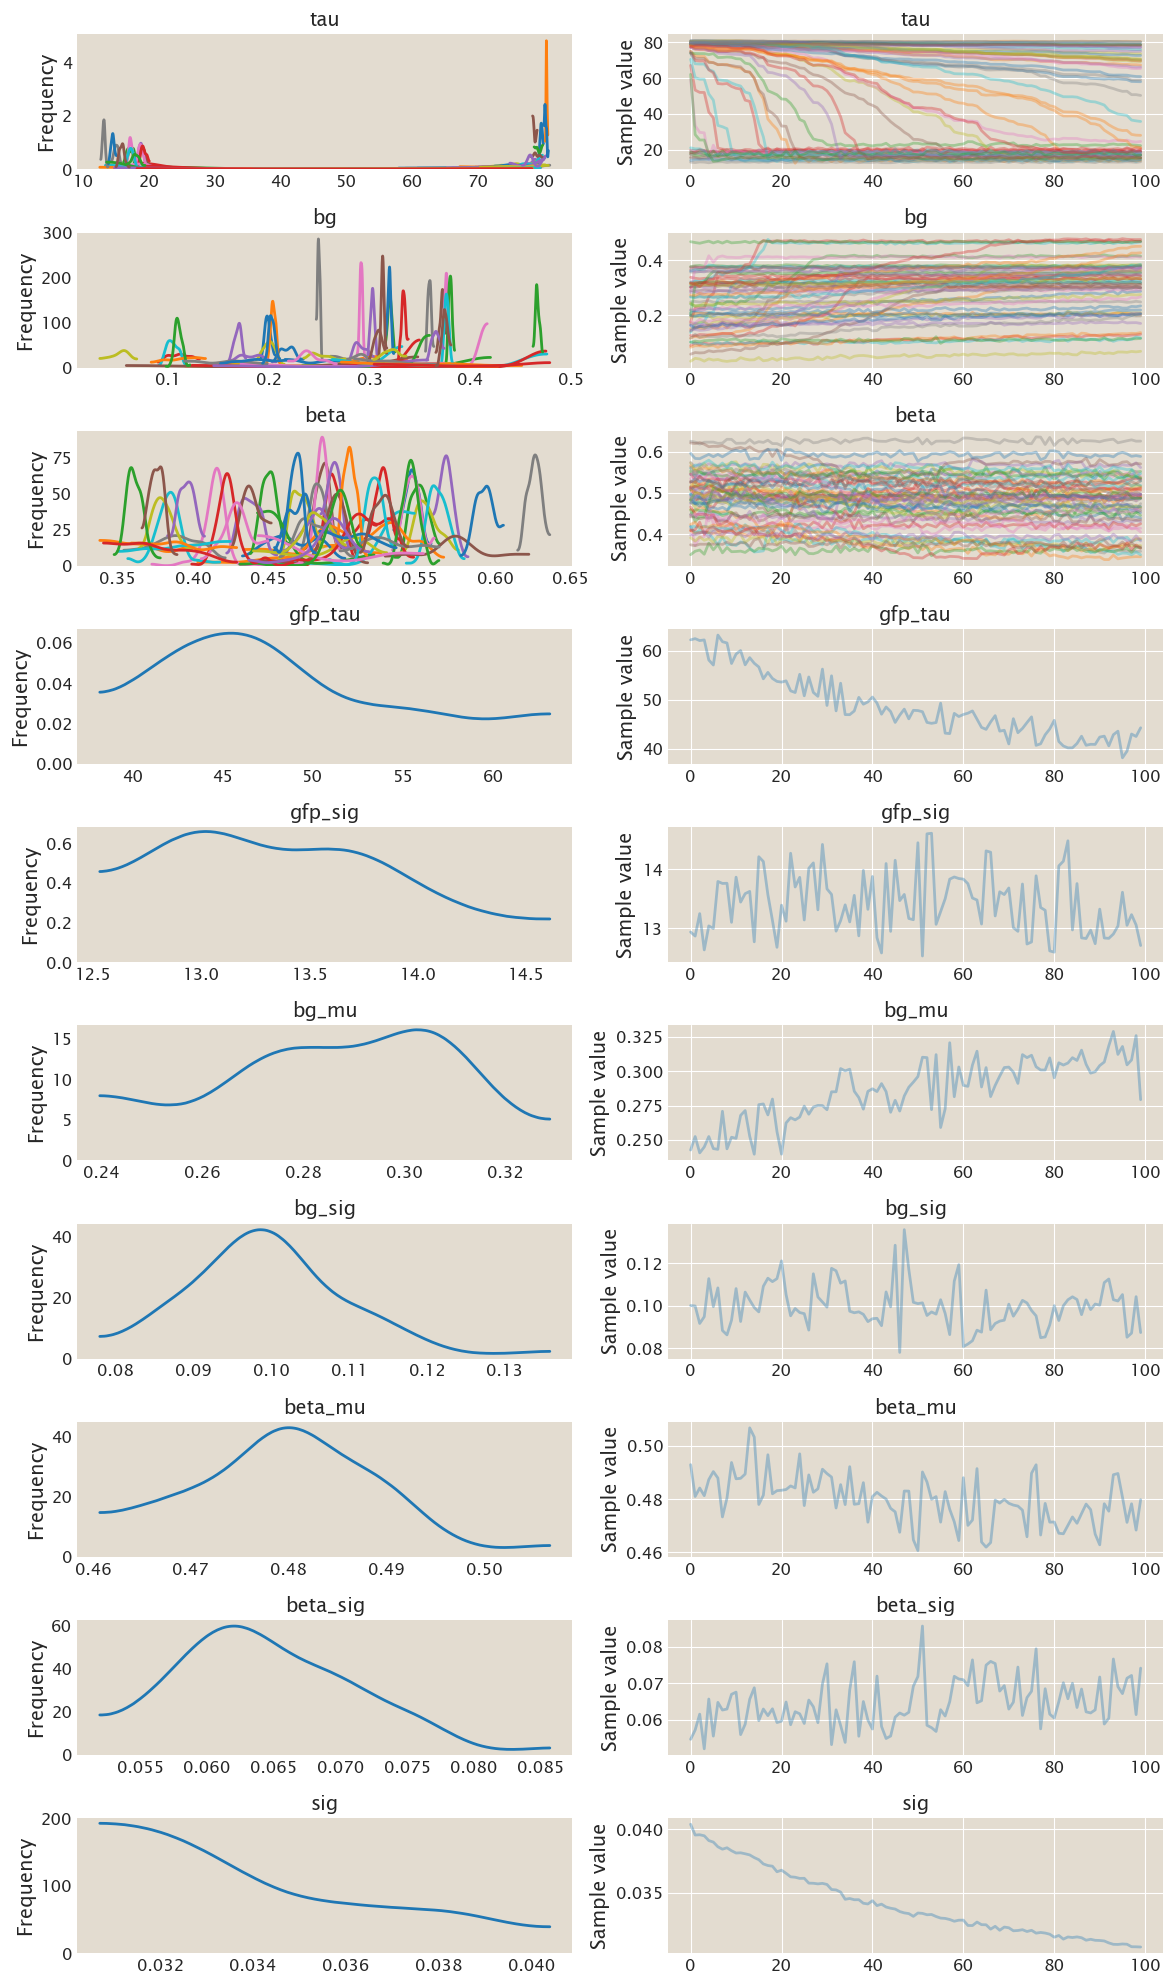

In [72]:
_ = pm.traceplot(delta_trace)

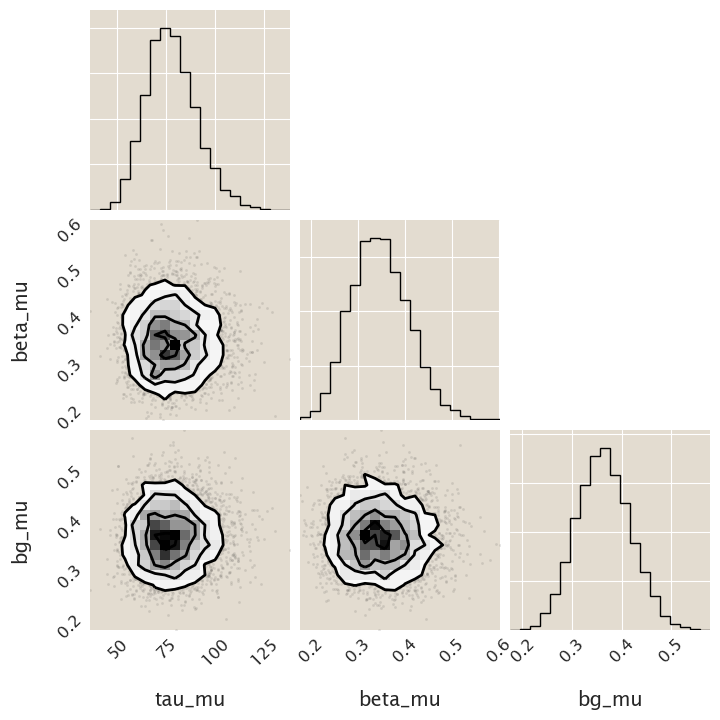

In [48]:
trace_df = pm.trace_to_dataframe(approx_trace)
_ = corner.corner(trace_df[['tau_mu', 'beta_mu', 'bg_mu']])